# Computer Homework 1
### Arad Mahdinejad Kashani, 400102028

## I. M-QAM Modulation
### I.i Implementations

In [1]:
import numpy as np

In [131]:
class QAM:
    def __init__(self, M, T, roll_off = 0.5):
        assert np.log2(M)%2 == 0
        
        self.n = int(np.log2(M)/2)
        self.T = T
        self.roll_off = roll_off
        
        self.bitstream = None
        self.points = self.__generate_constellation_points()
        self.constellation, self.inverse_constellation = self.__generate_constellation()
        self.mapped_points = None
        self.debug = None
        self.receiver_bitstream = None
        self.received_points = None

    def set_input(self, input, type='text'):
        """Sets the input string of the M-QAM modulation."""
        
        if type == 'text':
            self.bitstream = self.__to_binary(input)
            self.__map_to_m_qam()
        elif type == 'binary':
            self.bitstream = input
            self.__map_to_m_qam()
        else:
            print(f'Unknown input type\"{type}\"')

    def get_output(self):
        return self.__binary_to_output(self.receiver_bitstream)
       
    def __generate_constellation_points(self):
        """Generates constellation points for M-QAM modulation."""
        
        points = []
        for i in range(2 ** self.n):
            for j in range(2 ** self.n):
                points.append((2 * i - 2 ** self.n + 1, 2 * j - 2 ** self.n + 1))
        return points
    
    def __generate_constellation(self):
        """Generates a dictionary that maps constellation points to bit chunks"""
        constellation = {}
        inverse_constellation = {}
        for i, point in enumerate(self.points):
            bit_chunk = self.__binary_to_gray(format(i, f'0{2 * self.n}b'))
            constellation[point] = [int(bit) for bit in bit_chunk]
        for key, val in constellation.items():
            inverse_constellation[''.join(str(v) for v in val)] = key
        return constellation, inverse_constellation

    def __map_to_m_qam(self):
        """Pads the bitstream with zeros to match the length required by M-QAM and maps each chunk to its corresponding M-QAM point"""
        
        padding_length = int((2 * self.n) - (len(self.bitstream) % (2 * self.n))) if len(self.bitstream) % (2 * self.n) != 0 else 0
        padded_bitstream = self.bitstream + '0' * padding_length

        # Split the bitstream into chunks of size 2*self.n
        chunks = [padded_bitstream[i:i + (2 * self.n)] for i in range(0, len(padded_bitstream), (2 * self.n))]
        
        self.mapped_points = [self.inverse_constellation[chunk] for chunk in chunks]
    

    def __to_binary(self, input_string):
        return ''.join(format(ord(c), '08b') for c in input_string)
    
    def __binary_to_gray(self, binary_input):
        gray = binary_input[0]  # The first bit is copied as is
        gray += ''.join(
            str(int(binary_input[i-1]) ^ int(binary_input[i]))
            for i in range(1, len(binary_input)))
        return gray
    
    def __gray_to_binary(self, gray_input):
        binary = gray_input[0]
        for i in range(1, len(gray_input)):
            binary += str(int(binary[-1]) ^ int(gray_input[i]))
        return binary

    
    def __binary_to_output(self, binary_input):
        chars = [binary_input[i:i+8] for i in range(0, len(binary_input), 8)]
        return ''.join(chr(int(char, 2)) for char in chars)
    
    
    
    def transmit(self, t, fc):
        in_phase = np.zeros_like(t)
        quadrature = np.zeros_like(t)
        
        for idx, point in enumerate(self.mapped_points):
            in_phase += self.__pulse_waveform(point[0], idx, t)#self.__raised_cosine_waveform(point[0], idx, t)
            quadrature += self.__pulse_waveform(point[1], idx, t)#self.__raised_cosine_waveform(point[1], idx, t)
            
        return in_phase * np.cos(2*np.pi*fc*t) + quadrature * np.sin(2*np.pi*fc*t)

    def __raised_cosine_waveform(self, Am, idx, t):
        t_i = t - idx * self.T

        sinc_part = np.sinc(t_i / self.T)
        cos_part = np.cos(np.pi * self.roll_off * t_i / self.T)
        denominator = 1 - (2 * self.roll_off * t_i / self.T)**2

        waveform = Am * sinc_part * cos_part / np.where(denominator == 0, 1, denominator)
        return waveform
    
    def __pulse_waveform(self, Am, idx, t):
        return Am*(np.heaviside(t - idx*self.T,1) - np.heaviside(t - (idx+1)*self.T,1))

    def receive(self, received_signal, t, fc):
        I = np.zeros(len(self.mapped_points))
        Q = np.zeros(len(self.mapped_points))

        cos = np.cos(2 * np.pi * fc * t)
        sin = np.sin(2 * np.pi * fc * t)
        
        coef = 2 / self.T

        for idx in range(len(self.mapped_points)):
            I[idx] = np.trapz(received_signal * cos * self.__pulse_waveform(1, idx, t), t) * coef
            Q[idx] = np.trapz(received_signal * sin * self.__pulse_waveform(1, idx, t), t) * coef

        self.received_points = [(I[i], Q[i]) for i in range(len(I))]
        
        #print(received_points)

        bitstream = []
        for I, Q in self.received_points:
            point = complex(I, Q)
            bits = self.__point_to_bits(point)
            bitstream.extend(bits)
        bitstream = ''.join(str(c) for c in bitstream)
        self.receiver_bitstream = bitstream
        return bitstream
    
    def __point_to_bits(self, point):
        closest_point = min(self.constellation.keys(), key=lambda p: abs(complex(p[0],p[1]) - point))
        return self.constellation[closest_point]

[(-1, 1), (-1, 3), (-1, -3), (3, 3), (-1, -3), (3, 1), (-1, -1), (-3, 1), (-3, 3), (-3, -3), (-1, -3), (3, 1), (-1, -1), (-3, 1), (-3, 3), (-3, -3), (-1, -3), (-3, -1), (-3, 3), (-3, -3), (-1, -1), (-1, 3), (-1, -3), (-1, 1), (-1, -1), (-3, 1), (-1, -1), (-1, 3)]


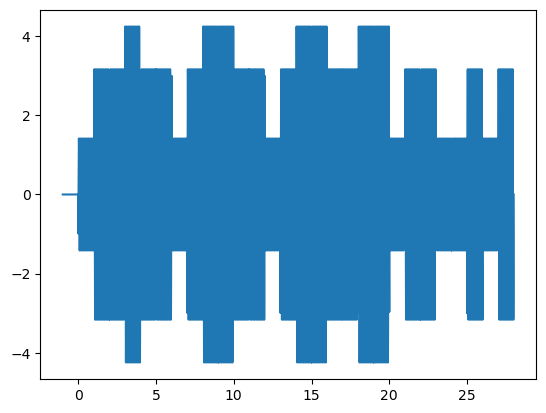

In [132]:
import matplotlib.pyplot as plt

M = 16
T=1
qam = QAM(M, T)

input_text = 'This is a test'

samples_per_symbol = 4_000
qam.set_input(input_text, type='text')
mapped_points = qam.mapped_points
print(mapped_points)

t = np.linspace(-1, len(qam.mapped_points)*qam.T, len(qam.mapped_points)*samples_per_symbol)  # Time vector

fc = 10
waveform = qam.transmit(t,fc)

plt.plot(t,waveform)
plt.show()

In [133]:
qam.bitstream

'0101010001101000011010010111001100100000011010010111001100100000011000010010000001110100011001010111001101110100'

In [135]:
qam.receiver_bitstream

'0101010001101000011010010111001100100000011010010111001100100000011000010010000001110100011001010111001101110100'

In [134]:
qam.receive(waveform, t, fc)
qam.get_output()

'This is a test'

In [129]:
qam.constellation

{(-3, -3): [0, 0, 0, 0],
 (-3, -1): [0, 0, 0, 1],
 (-3, 1): [0, 0, 1, 1],
 (-3, 3): [0, 0, 1, 0],
 (-1, -3): [0, 1, 1, 0],
 (-1, -1): [0, 1, 1, 1],
 (-1, 1): [0, 1, 0, 1],
 (-1, 3): [0, 1, 0, 0],
 (1, -3): [1, 1, 0, 0],
 (1, -1): [1, 1, 0, 1],
 (1, 1): [1, 1, 1, 1],
 (1, 3): [1, 1, 1, 0],
 (3, -3): [1, 0, 1, 0],
 (3, -1): [1, 0, 1, 1],
 (3, 1): [1, 0, 0, 1],
 (3, 3): [1, 0, 0, 0]}

In [130]:
qam.inverse_constellation

{'0000': (-3, -3),
 '0001': (-3, -1),
 '0011': (-3, 1),
 '0010': (-3, 3),
 '0110': (-1, -3),
 '0111': (-1, -1),
 '0101': (-1, 1),
 '0100': (-1, 3),
 '1100': (1, -3),
 '1101': (1, -1),
 '1111': (1, 1),
 '1110': (1, 3),
 '1010': (3, -3),
 '1011': (3, -1),
 '1001': (3, 1),
 '1000': (3, 3)}

### I.ii Analysis

In [136]:
from random import getrandbits
random_string = format(getrandbits(10_000), '0b')
len(random_string)

10000

In [137]:
M = 16
T = 1
fc = 2.5
qam = QAM(M, T)

qam.set_input(random_string, type='binary')
samples_per_symbol = 10*int(fc/T*2) # arbitrary formula
t = np.linspace(-1, len(qam.mapped_points)*qam.T, len(qam.mapped_points)*samples_per_symbol)

waveform = qam.transmit(t,fc)

In [139]:
def AWGN_channel(signal, SNR):
    sig_avg_watts = np.mean(signal**2)
    sig_avg_db = 10 * np.log10(sig_avg_watts)

    noise_avg_db = sig_avg_db - SNR
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    noise = np.random.normal(0, np.sqrt(noise_avg_watts), len(signal))
    
    return signal + noise

SNRs = np.r_[-10:30 + 1]
BERs = []
SERs = []
actual_bits = qam.bitstream
for SNR in SNRs:
    print(f'Calculating for {SNR = }dB')
    noisy_signal = AWGN_channel(waveform, SNR)
    qam.receive(noisy_signal, t, fc)
    symbol_guesses = [min(qam.constellation.keys(), key=lambda p: abs(complex(p[0],p[1]) - complex(point[0],point[1])))
                      for point in qam.received_points]
    bit_errors = np.sum(np.array(list(actual_bits)) != np.array(list(qam.receiver_bitstream)))
    symbol_errors = np.sum(np.array(qam.mapped_points) != np.array(symbol_guesses))
    
    BERs.append(bit_errors/len(actual_bits))
    SERs.append(symbol_errors/len(qam.mapped_points))

Calculating for SNR = -10dB
Calculating for SNR = -9dB
Calculating for SNR = -8dB
Calculating for SNR = -7dB
Calculating for SNR = -6dB
Calculating for SNR = -5dB
Calculating for SNR = -4dB
Calculating for SNR = -3dB
Calculating for SNR = -2dB
Calculating for SNR = -1dB
Calculating for SNR = 0dB
Calculating for SNR = 1dB
Calculating for SNR = 2dB
Calculating for SNR = 3dB
Calculating for SNR = 4dB
Calculating for SNR = 5dB
Calculating for SNR = 6dB
Calculating for SNR = 7dB
Calculating for SNR = 8dB
Calculating for SNR = 9dB
Calculating for SNR = 10dB
Calculating for SNR = 11dB
Calculating for SNR = 12dB
Calculating for SNR = 13dB
Calculating for SNR = 14dB
Calculating for SNR = 15dB
Calculating for SNR = 16dB
Calculating for SNR = 17dB
Calculating for SNR = 18dB
Calculating for SNR = 19dB
Calculating for SNR = 20dB
Calculating for SNR = 21dB
Calculating for SNR = 22dB
Calculating for SNR = 23dB
Calculating for SNR = 24dB
Calculating for SNR = 25dB
Calculating for SNR = 26dB
Calculatin

In [154]:
BER = {}
SER = {}
Ms = [4, 16, 64, 256]
for M in Ms:
    print(f'{M}-QAM:')
    T = 1
    fc = 2
    qam = QAM(M, T)

    qam.set_input(random_string, type='binary')
    samples_per_symbol = 4*int(fc/T*2) # arbitrary formula
    t = np.linspace(-1, len(qam.mapped_points)*qam.T, len(qam.mapped_points)*samples_per_symbol)

    waveform = qam.transmit(t,fc)
    SNRs = np.r_[-10:30 + 1]
    BERs = []
    SERs = []
    actual_bits = qam.bitstream
    for SNR in SNRs:
        print(f'Calculating for {SNR = }dB')
        noisy_signal = AWGN_channel(waveform, SNR)
        qam.receive(noisy_signal, t, fc)
        symbol_guesses = [min(qam.constellation.keys(), key=lambda p: abs(complex(p[0],p[1]) - complex(point[0],point[1])))
                        for point in qam.received_points]
        bit_errors = np.sum(np.array(list(actual_bits)) != np.array(list(qam.receiver_bitstream)[:len(actual_bits)])) + np.abs(len(actual_bits) - len(qam.receiver_bitstream))
        symbol_errors = np.sum(np.array(qam.mapped_points) != np.array(symbol_guesses)[:len(qam.mapped_points)]) + np.abs(len(symbol_guesses))
        
        BERs.append(bit_errors/len(actual_bits))
        SERs.append(symbol_errors/len(qam.mapped_points))
    BER[M] = BERs
    SER[M] = SERs

4-QAM:
Calculating for SNR = -10dB
Calculating for SNR = -9dB
Calculating for SNR = -8dB
Calculating for SNR = -7dB
Calculating for SNR = -6dB
Calculating for SNR = -5dB
Calculating for SNR = -4dB
Calculating for SNR = -3dB
Calculating for SNR = -2dB
Calculating for SNR = -1dB
Calculating for SNR = 0dB
Calculating for SNR = 1dB
Calculating for SNR = 2dB
Calculating for SNR = 3dB
Calculating for SNR = 4dB
Calculating for SNR = 5dB
Calculating for SNR = 6dB
Calculating for SNR = 7dB
Calculating for SNR = 8dB
Calculating for SNR = 9dB
Calculating for SNR = 10dB
Calculating for SNR = 11dB
Calculating for SNR = 12dB
Calculating for SNR = 13dB
Calculating for SNR = 14dB
Calculating for SNR = 15dB
Calculating for SNR = 16dB
Calculating for SNR = 17dB
Calculating for SNR = 18dB
Calculating for SNR = 19dB
Calculating for SNR = 20dB
Calculating for SNR = 21dB
Calculating for SNR = 22dB
Calculating for SNR = 23dB
Calculating for SNR = 24dB
Calculating for SNR = 25dB
Calculating for SNR = 26dB
Cal

In [157]:
from scipy import special
def qfunc(x):
    return 0.5-0.5*special.erf(x/np.sqrt(2))

def BER_function(M,SNR):
    lam = 10**(SNR/10)
    return 1 - (1-2*(np.sqrt(M)-1)/np.sqrt(M)*qfunc(np.sqrt(3*lam/(M-1))))**2

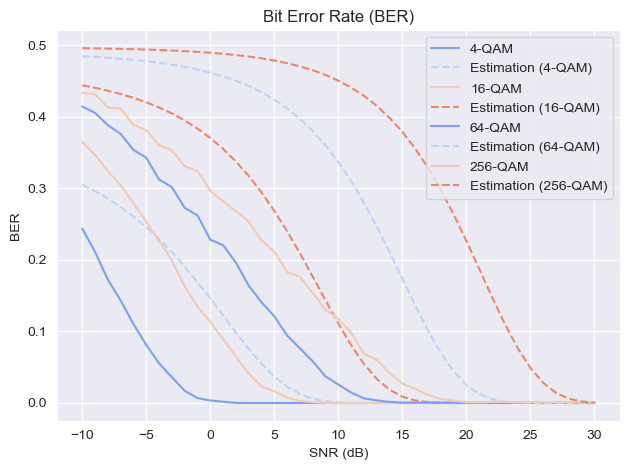

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')

for M, BER_M in BER.items():
    estimation = [BER_function(M, SNR) for SNR in SNRs]
    plt.plot(SNRs, BER_M, label=f"{M}-QAM")
    plt.plot(SNRs, estimation, linestyle='--', label=f"Estimation ({M}-QAM)")

plt.title(f'Bit Error Rate (BER)')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True)

sns.set_palette("cividis", len(BER))
plt.legend()
plt.tight_layout()

plt.show()

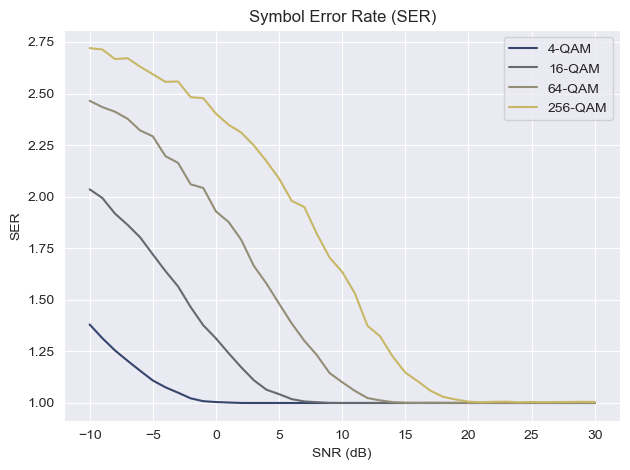

In [164]:
sns.set_style('darkgrid')

for M, SER_M in SER.items():
    plt.plot(SNRs, SER_M, label=f"{M}-QAM")

plt.title(f'Symbol Error Rate (SER)')
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.grid(True)

sns.set_palette("coolwarm", len(BER))
plt.legend()
plt.tight_layout()

plt.show()

### I.iii Examination

For SNR = -100dB, $\lambda_{avg} = 10^{-10}$ so $Q(\sqrt{\frac{3}{M-1}\lambda_{avg}}) = Q(\sqrt{\frac{3}{M-1}10^{-10}}) \approx 1$.

Therefore:
$$
BER = 1 - (1-2\frac{\sqrt{M}-1}{\sqrt{M}})^2 = 4 \frac{\sqrt{M}-1}{M}
$$

4-QAM...
16-QAM...
64-QAM...
256-QAM...


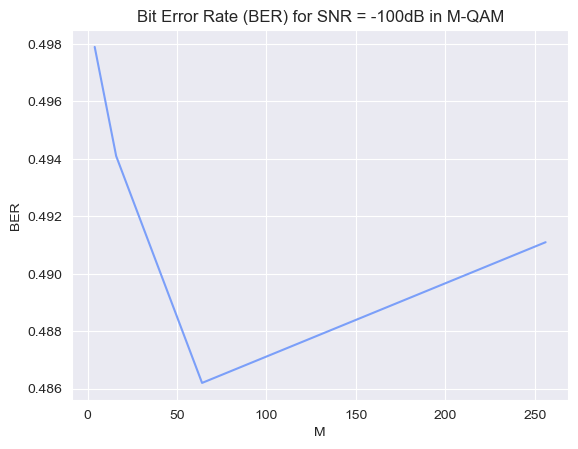

In [170]:
iii_BERs = []

for M in Ms:
    print(f'{M}-QAM...')
    T = 1
    fc = 2
    qam = QAM(M, T)

    qam.set_input(random_string, type='binary')
    samples_per_symbol = 4*int(fc/T*2) # arbitrary formula
    t = np.linspace(-1, len(qam.mapped_points)*qam.T, len(qam.mapped_points)*samples_per_symbol)

    waveform = qam.transmit(t,fc)

    noisy_signal = AWGN_channel(waveform, SNR=-100)
    qam.receive(noisy_signal, t, fc)
    ber = np.sum(np.array(list(qam.bitstream)) != np.array(list(qam.receiver_bitstream)[:len(qam.bitstream)])) + np.abs(len(qam.bitstream) - len(qam.receiver_bitstream))

    iii_BERs.append(ber/len(actual_bits))

sns.set_style('darkgrid')

plt.plot(Ms, iii_BERs)

plt.title('Bit Error Rate (BER) for SNR = -100dB in M-QAM')
plt.xlabel('M')
plt.ylabel('BER')
plt.grid(True)

plt.show()

### I.iv Scatter Plots

In [184]:
SNRs = [-10, 0, 10, 20, 25, 30]

input_string = format(getrandbits(1000), '0b')

M = 16
T = 1
fc = 2.5

qam = QAM(M, T)

qam.set_input(input_string, type='binary')
samples_per_symbol = 10*int(fc/T*2) # arbitrary formula
t = np.linspace(-1, len(qam.mapped_points)*qam.T, len(qam.mapped_points)*samples_per_symbol)

waveform = qam.transmit(t,fc)

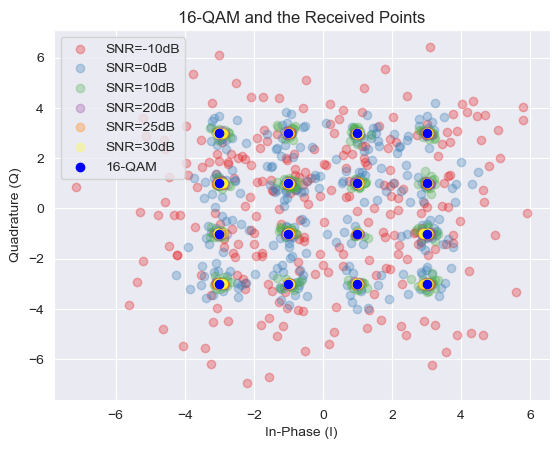

In [194]:
X_qam = [p[0] for p in qam.points]
Y_qam = [p[1] for p in qam.points]

colors = sns.color_palette("Set1", len(SNRs))
for i, SNR in enumerate(SNRs):
    noisy_signal = AWGN_channel(waveform, SNR)
    qam.receive(noisy_signal, t, fc)
    X_received = [p[0] for p in qam.received_points]
    Y_received = [p[1] for p in qam.received_points]
    plt.scatter(X_received, Y_received, color=colors[i], alpha=0.3, label=f"{SNR=}dB")
plt.scatter(X_qam, Y_qam, color='blue', label='16-QAM')
plt.title('16-QAM and the Received Points')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.grid(True)
plt.legend()
plt.show()

## II. Convolutional Coding
### II.i Theoretical Part
Assume $b[n]$ in the input, $a[n]$ is before the register and $a[n+i]$ is after the i-th register, and let $y[n]$ be the output.

$$
a[n] = b[n] \oplus a[n+2] \oplus a[n+3] \\
y[n] = a[n] \oplus a[n+1] = b[n] \oplus a[n+1] \oplus a[n+2] \oplus a[n+3] \\
$$

The first equation implies that:
$$
a[n+1] = b[n+1] \oplus a[n+3] \oplus a[n+4] \\
a[n+2] = b[n+2] \oplus a[n+4] \oplus a[n+5] \\
a[n+3] = b[n+3] \oplus a[n+5] \oplus a[n+6]
$$
Knowing $c[n] \oplus c[n] = 0$ we can substitue for $y[n]$:
$$
y[n] = b[n] \oplus b[n+1] \oplus b[n+2] \oplus b[n+3] \oplus a[n+6]
$$

This cannot be simplified more, as $a[n+6]$ has memory of even earlier bits.
Now take $b[n] \oplus y[n]$:
$$
y[n] \oplus b[n] = b[n+1] \oplus b[n+2] \oplus b[n+3] \oplus a[n+6]
$$

Which are values that we are completely from previous bits of the message. This means that if we use some sort of interleaved bitstream such as $\dots b_{i-1}y_{i-1}b_iy_ib_{i+1}y_{i+1} \dots$  we can just XOR the two bits and perform a parity check. Having the memory of previous bits, they can be also used in the parity check to see if there is an error or not.